<a href="https://colab.research.google.com/github/Bodigeramakrishna/sarcasm-detection-use-BILSTM/blob/main/sacasm_tw_2_(3)_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install pandas numpy scikit-learn torch transformers tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
pip install --upgrade transformers

In [4]:
pip install transformers==4.41.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 99.9 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader



from transformers import BertTokenizer, BertModel, BertConfig, get_linear_schedule_with_warmup
from transformers.optimization import AdamW
from tqdm import tqdm


In [6]:
# Load the dataset
# Replace 'your_dataset.csv' with your actual dataset path
df = pd.read_csv('/content/train-1.csv')  # Ensure the file path is correct

# Display basic information
print(f"Total samples: {len(df)}")
#df=df[0:10000]
print(df.head())
print(df.shape)

Total samples: 20033
   Y                                               text  Y.1
0  1  thirtysomething scientists unveil doomsday clo...    1
1  1  inclement weather prevents liar from getting t...    1
2  1  mother comes pretty close to using word stream...    1
3  1  richard branson global warming donation nearly...    1
4  1  shadow government getting too large to meet in...    1
(20033, 3)


In [7]:
df=df.dropna()

In [8]:
print(df)

       Y                                               text  Y.1
0      1  thirtysomething scientists unveil doomsday clo...    1
1      1  inclement weather prevents liar from getting t...    1
2      1  mother comes pretty close to using word stream...    1
3      1  richard branson global warming donation nearly...    1
4      1  shadow government getting too large to meet in...    1
...   ..                                                ...  ...
20028  0  autopsy reveals that former nhl player todd ew...    0
20029  0                            capital in 21st century    0
20030  0  in most states the middle class is now growing...    0
20031  0          emotional intelligence needs moral rudder    0
20032  0  the 8 most important lessons from my first yea...    0

[20033 rows x 3 columns]


In [9]:
df['text'] = df['text'].fillna("").astype(str)
x, xt, y, yt = train_test_split(
    df['text'].values,
    df['Y'].values,
    test_size=0.9,
    random_state=15,
    stratify=df['Y'].values
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    x,
    y,
    test_size=0.3,
    random_state=25,
    #stratify=df['y'].values
)


In [10]:
print(train_texts.size)

1402


In [11]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define maximum sequence length
MAX_LEN = 128

def tokenize_texts(texts, tokenizer, max_len):
    return tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

# Tokenize training and validation texts
train_encodings = tokenize_texts(train_texts, tokenizer, MAX_LEN)
val_encodings = tokenize_texts(val_texts, tokenizer, MAX_LEN)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
class SarcasmDataset(Dataset):
    def __init__(self, encodings, labels):
        self.input_ids = encodings['input_ids']
        self.attention_mask = encodings['attention_mask']
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

# Create Dataset objects
train_dataset = SarcasmDataset(train_encodings, train_labels)
val_dataset = SarcasmDataset(val_encodings, val_labels)


In [13]:
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [14]:
class DoubleBERT(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', num_labels=2):
        super(DoubleBERT, self).__init__()
        # First BERT model for embeddings
        self.bert_encoder = BertModel.from_pretrained(bert_model_name)

        # Second BERT model for classification
        self.bert_classifier = BertModel.from_pretrained(bert_model_name)

        # Classification layer
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert_classifier.config.hidden_size * 2, num_labels)

    def forward(self, input_ids, attention_mask):
        # Pass through the first BERT encoder
        encoder_outputs = self.bert_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        encoder_cls = encoder_outputs.last_hidden_state[:,0,:]  # CLS token

        # Pass through the second BERT classifier
        classifier_outputs = self.bert_classifier(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        classifier_cls = classifier_outputs.last_hidden_state[:,0,:]  # CLS token

        # Concatenate CLS tokens from both BERTs
        combined = torch.cat((encoder_cls, classifier_cls), dim=1)
        combined = self.dropout(combined)

        # Final classification layer
        logits = self.classifier(combined)

        return logits


In [15]:

# Check for GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

# Initialize the model
model = DoubleBERT()
model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

# Define number of training steps
epochs = 3
total_steps = len(train_loader) * epochs

# Define scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Define loss function
criterion = nn.CrossEntropyLoss()


Using device: cuda


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
def train_epoch(model, data_loader, optimizer, scheduler, device, criterion):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(outputs, labels)
        total_loss += loss.item()

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(data_loader)
    return avg_loss

def eval_model(model, data_loader, device, criterion):
    model.eval()
    total_loss = 0
    preds = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            preds.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(true_labels, preds)
    report = classification_report(true_labels, preds, digits=4)
    return avg_loss, accuracy, report


In [17]:
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print("-" * 20)

    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device, criterion)
    print(f"Training Loss: {train_loss:.4f}")

    val_loss, val_accuracy, val_report = eval_model(model, val_loader, device, criterion)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print("Classification Report:")
    print(val_report)



Epoch 1/3
--------------------


Training: 100%|██████████| 88/88 [00:55<00:00,  1.58it/s]


Training Loss: 0.4995


Evaluating: 100%|██████████| 38/38 [00:08<00:00,  4.71it/s]


Validation Loss: 0.3246
Validation Accuracy: 0.8619
Classification Report:
              precision    recall  f1-score   support

           0     0.8563    0.8910    0.8733       321
           1     0.8689    0.8286    0.8483       280

    accuracy                         0.8619       601
   macro avg     0.8626    0.8598    0.8608       601
weighted avg     0.8622    0.8619    0.8616       601


Epoch 2/3
--------------------


Training: 100%|██████████| 88/88 [00:58<00:00,  1.50it/s]


Training Loss: 0.1490


Evaluating: 100%|██████████| 38/38 [00:08<00:00,  4.40it/s]


Validation Loss: 0.5403
Validation Accuracy: 0.8486
Classification Report:
              precision    recall  f1-score   support

           0     0.8194    0.9190    0.8664       321
           1     0.8921    0.7679    0.8253       280

    accuracy                         0.8486       601
   macro avg     0.8558    0.8434    0.8459       601
weighted avg     0.8533    0.8486    0.8473       601


Epoch 3/3
--------------------


Training: 100%|██████████| 88/88 [00:58<00:00,  1.50it/s]


Training Loss: 0.0263


Evaluating: 100%|██████████| 38/38 [00:08<00:00,  4.41it/s]

Validation Loss: 0.6418
Validation Accuracy: 0.8502
Classification Report:
              precision    recall  f1-score   support

           0     0.8448    0.8816    0.8628       321
           1     0.8571    0.8143    0.8352       280

    accuracy                         0.8502       601
   macro avg     0.8510    0.8480    0.8490       601
weighted avg     0.8505    0.8502    0.8499       601



In [18]:
class_counts = pd.Series(y).value_counts().sort_index()  # Adjust if using df directly
total_samples = sum(class_counts)
class_weights = torch.tensor([total_samples / count for count in class_counts], dtype=torch.float32).to(device)

# Define weighted cross-entropy loss
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

# Define number of training steps
epochs = 3
total_steps = len(train_loader) * epochs

# Define scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

def train_epoch(model, data_loader, optimizer, scheduler, device, criterion):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(outputs, labels)
        total_loss += loss.item()

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(data_loader)
    return avg_loss

def eval_model(model, data_loader, device, criterion):
    model.eval()
    total_loss = 0
    preds = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            preds.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(true_labels, preds)
    report = classification_report(true_labels, preds, digits=4)
    return avg_loss, accuracy, report

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print("-" * 20)

    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device, criterion)
    print(f"Training Loss: {train_loss:.4f}")

    val_loss, val_accuracy, val_report = eval_model(model, val_loader, device, criterion)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print("Classification Report:")
    print(val_report)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/3
--------------------


Training: 100%|██████████| 88/88 [00:59<00:00,  1.48it/s]


Training Loss: 0.1387


Evaluating: 100%|██████████| 38/38 [00:08<00:00,  4.50it/s]


Validation Loss: 0.7245
Validation Accuracy: 0.8619
Classification Report:
              precision    recall  f1-score   support

           0     0.8269    0.9377    0.8788       321
           1     0.9156    0.7750    0.8395       280

    accuracy                         0.8619       601
   macro avg     0.8713    0.8563    0.8591       601
weighted avg     0.8682    0.8619    0.8605       601


Epoch 2/3
--------------------


Training: 100%|██████████| 88/88 [00:58<00:00,  1.49it/s]


Training Loss: 0.0124


Evaluating: 100%|██████████| 38/38 [00:08<00:00,  4.43it/s]


Validation Loss: 1.0150
Validation Accuracy: 0.8502
Classification Report:
              precision    recall  f1-score   support

           0     0.8217    0.9190    0.8676       321
           1     0.8926    0.7714    0.8276       280

    accuracy                         0.8502       601
   macro avg     0.8571    0.8452    0.8476       601
weighted avg     0.8547    0.8502    0.8490       601


Epoch 3/3
--------------------


Training: 100%|██████████| 88/88 [00:58<00:00,  1.49it/s]


Training Loss: 0.0012


Evaluating: 100%|██████████| 38/38 [00:08<00:00,  4.46it/s]

Validation Loss: 0.9993
Validation Accuracy: 0.8552
Classification Report:
              precision    recall  f1-score   support

           0     0.8362    0.9065    0.8700       321
           1     0.8814    0.7964    0.8368       280

    accuracy                         0.8552       601
   macro avg     0.8588    0.8515    0.8534       601
weighted avg     0.8573    0.8552    0.8545       601



In [19]:
# Save the model
model_save_path = 'double_bert_sarcasm_detector.pt'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to double_bert_sarcasm_detector.pt


In [20]:
# To load the model later
model = DoubleBERT()
model.load_state_dict(torch.load('double_bert_sarcasm_detector.pt'))
model.to(device)
model.eval()

# Function to predict sarcasm
def predict_sarcasm(text, model, tokenizer, device, max_len=128):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, prediction = torch.max(outputs, dim=1)

    return prediction.item()

# Example usage
sample_text = "I just love getting stuck in traffic for hours!"
prediction = predict_sarcasm(sample_text, model, tokenizer, device)
label = "Sarcastic" if prediction == 1 else "Not Sarcastic"
print(f"Prediction: {label}")


Prediction: Not Sarcastic


In [21]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [22]:
def eval_model(model, data_loader, device, criterion):
    model = model.eval()
    val_loss = 0
    correct_predictions = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, dim=1)

            # Collect predictions and true labels
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

            correct_predictions += torch.sum(preds == labels)

    # Calculate accuracy
    val_accuracy = correct_predictions.double() / len(data_loader.dataset)

    return val_loss / len(data_loader), val_accuracy, val_preds, val_labels


In [23]:
# Evaluate the model
val_loss, val_accuracy, val_preds, val_labels = eval_model(model, val_loader, device, criterion)


In [24]:
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


Validation Loss: 0.9992549243401491
Validation Accuracy: 0.8552412645590682


In [25]:
from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(val_labels, val_preds))



Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87       321
           1       0.88      0.80      0.84       280

    accuracy                           0.86       601
   macro avg       0.86      0.85      0.85       601
weighted avg       0.86      0.86      0.85       601



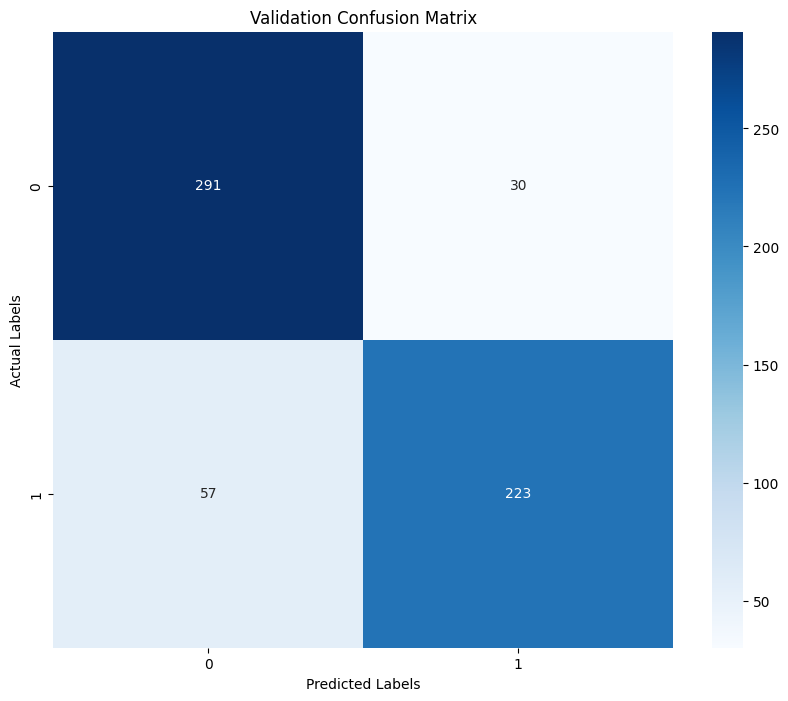

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [27]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(val_labels, val_preds, average='weighted')
print(f"Weighted Precision: {precision}")
print(f"Weighted Recall: {recall}")
print(f"Weighted F1 Score: {f1}")


Weighted Precision: 0.8572726002752671
Weighted Recall: 0.8552412645590682
Weighted F1 Score: 0.8544959079088369


In [28]:
false_negatives = [val_texts[i] for i, (pred, true) in enumerate(zip(val_preds, val_labels)) if pred == 0 and true == 1]
false_positives = [val_texts[i] for i, (pred, true) in enumerate(zip(val_preds, val_labels)) if pred == 1 and true == 0]

print("Common False Negatives (sarcasm missed):")
for text in false_negatives[:5]:
    print(text)

print("\nCommon False Positives (non-sarcastic classified as sarcastic):")
for text in false_positives[:5]:
    print(text)


Common False Negatives (sarcasm missed):
vocalist leaves journey tribute band over creative differences
trump outlines bold vision for nation next mass protests
sanders supporters viciously attack bernie sanders after he criticizes mistakes of 2016 sanders campaign
philip morris please talk to your cooler children about cigarettes 
three escaping legislators shot from senate guard tower

Common False Positives (non-sarcastic classified as sarcastic):
breaking ufos spotted on classy porcelain dinnerware
nervous flyer screwed by pals who secretly pack dildo in his bag nsfw 
look iconic jean company introduces gay pride line
republicans north korea considering nuclear option
little girl attempts to play with game boy flabbergasted by lack of touchscreen


In [29]:
from sklearn.metrics import f1_score

class_f1_scores = f1_score(val_labels, val_preds, average=None)
print(f"Class-wise F1-Scores: {class_f1_scores}")


Class-wise F1-Scores: [0.86995516 0.83677298]


In [30]:
def eval_model(model, data_loader, device, criterion):
    model = model.eval()
    val_loss = 0
    correct_predictions = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, dim=1)

            # Collect predictions and true labels
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

            correct_predictions += torch.sum(preds == labels).item()  # Ensure it's a Python number

    # Calculate accuracy as a float
    val_accuracy = correct_predictions / len(data_loader.dataset)  # This is now a float

    return val_loss / len(data_loader), float(val_accuracy), val_preds, val_labels  # Ensure val_accuracy is a float


In [31]:
val_loss, val_accuracy, val_preds, val_labels = eval_model(model, val_loader, device, criterion)

In [32]:
from sklearn.metrics import roc_curve, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, RocCurveDisplay, PrecisionRecallDisplay

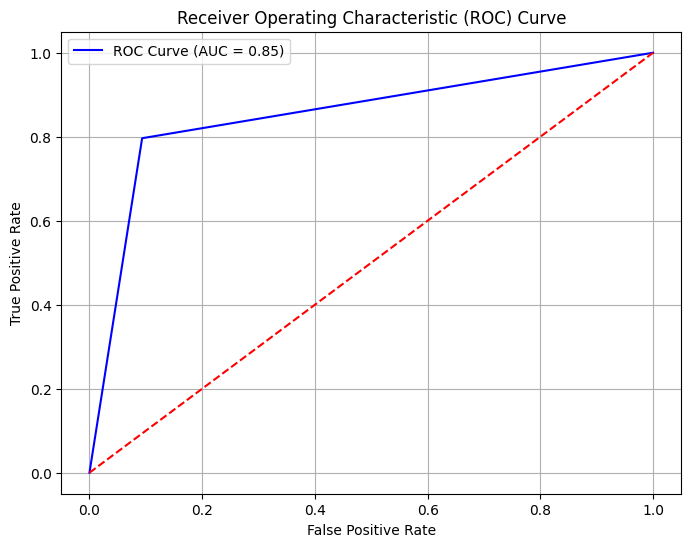

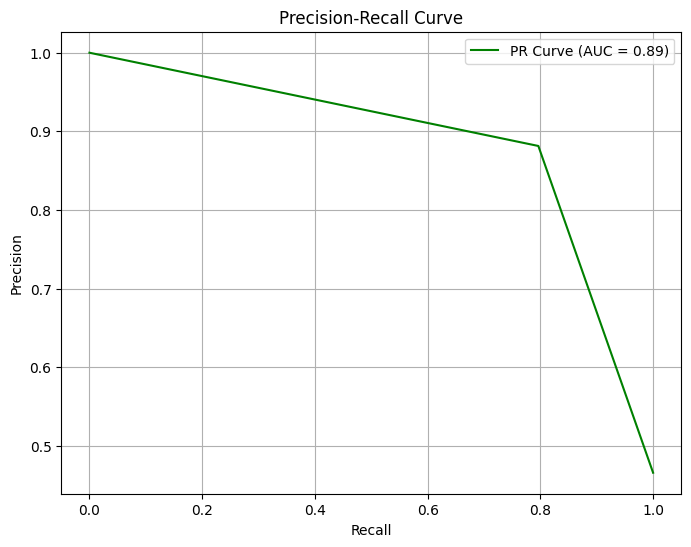

In [34]:
# Evaluation
val_loss, val_accuracy, val_preds, val_labels = eval_model(model, val_loader, device, criterion)
true_labels = val_labels

# Convert model outputs to probabilities if needed (you may already have them)
# If val_preds are logits or class labels, modify this based on your model
# Below assumes val_preds are already probabilities for class 1 (binary classification)
val_preds_probs = np.array([1 if pred == 1 else 0 for pred in val_preds])  # Replace with real probabilities if available

#  ROC Curve
def plot_roc_curve(true_labels, predictions):
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
# Precision-Recall Curve
def plot_precision_recall_curve(true_labels, predictions):
    precision, recall, _ = precision_recall_curve(true_labels, predictions)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', label=f'PR Curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

 # Call the plotting functions
plot_roc_curve(true_labels, val_preds_probs)
plot_precision_recall_curve(true_labels, val_preds_probs)

In [35]:
train_losses = []
val_losses = []
val_accuracies = []


In [36]:
# After training step
train_losses.append(train_loss)

# After validation step
val_losses.append(val_loss)
val_accuracies.append(val_accuracy)


In [37]:
# Verify lengths before plotting
print(f"Length of train_losses: {len(train_losses)}")
print(f"Length of val_losses: {len(val_losses)}")
print(f"Length of val_accuracies: {len(val_accuracies)}")


Length of train_losses: 1
Length of val_losses: 1
Length of val_accuracies: 1


In [38]:
pip install shap

In [39]:
from sklearn.base import BaseEstimator, ClassifierMixin
import torch.nn.functional as F
class SklearnCompatibleBERT(BaseEstimator, ClassifierMixin):
      def __init__(self, model, device):
              self.model = model
              self.device = device
      def fit(self, X, y=None):
                # No fitting in this context (model already trained)
                        return self
      def predict(self, X):
                self.model.eval()
                with torch.no_grad():
                    inputs = {k: v.to(self.device) for k, v in X.items()}
                    outputs = self.model(**inputs)
                    logits = outputs.logits if hasattr(outputs, "logits") else outputs
                    preds = torch.argmax(logits, dim=1).cpu().numpy()
                return preds


In [44]:
list_of_texts = []
list_of_labels = []

for batch in val_loader:
    # Assuming batch is a dict with 'input_ids', 'attention_mask', and 'labels'
        input_ids = batch['input_ids']
        labels = batch['labels']
                # Decode input_ids back to text if needed (optional)
        texts = tokenizer.batch_decode(input_ids, skip_special_tokens=True)

        list_of_texts.extend(texts)
        list_of_labels.extend(labels.numpy())  # or .tolist() if you prefer


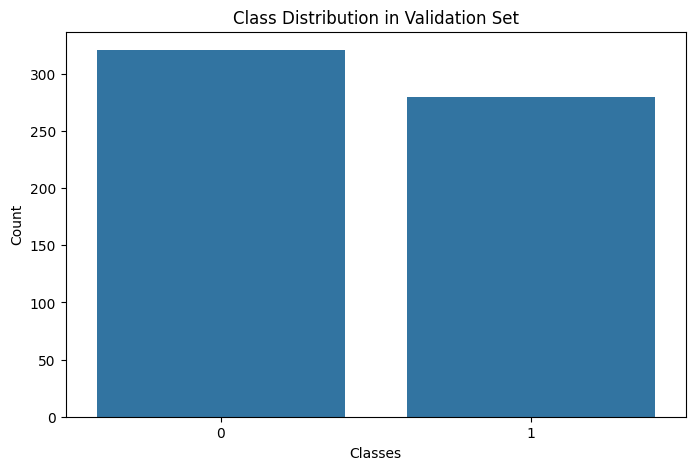

Misclassifications:
True: 1, Predicted: 0
True: 1, Predicted: 0
True: 0, Predicted: 1
True: 1, Predicted: 0
True: 0, Predicted: 1
True: 1, Predicted: 0
True: 1, Predicted: 0
True: 1, Predicted: 0
True: 1, Predicted: 0
True: 1, Predicted: 0


In [45]:
def plot_class_distribution(true_labels):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=true_labels)
    plt.title('Class Distribution in Validation Set')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.show()

# Call the function
plot_class_distribution(true_labels)

# Analyzing Misclassifications
def analyze_misclassifications(true_labels, val_preds):
    misclassified = [(true, pred) for true, pred in zip(true_labels, val_preds) if true != pred]
    print("Misclassifications:")
    for true, pred in misclassified[:10]:  # Print the first 10 misclassifications
        print(f"True: {true}, Predicted: {pred}")

# Call the function
analyze_misclassifications(true_labels, val_preds)


In [67]:
import matplotlib.pyplot as plt

def plot_misclassified_samples(X, y_true, y_pred, max_samples=10):
    misclassified_indices = [i for i, (yt, yp) in enumerate(zip(y_true, y_pred)) if yt != yp]
    print(f"Total misclassified: {len(misclassified_indices)}")
    num_to_plot = min(max_samples, len(misclassified_indices))
    for i in range(num_to_plot):
        idx = misclassified_indices[i]
        print(f"\nSample {i + 1}")
        print(f"Text: {X[idx]}")
        print(f"True label: {y_true[idx]}")
        print(f"Predicted label: {y_pred[idx]}")

In [68]:
X_val = list_of_texts                          # list of original texts
y_val = np.array(list_of_labels)              # true labels as NumPy array

# Make predictions (assuming you already tokenized and used your model)
encoded_val = tokenizer(X_val, padding=True, truncation=True, return_tensors='pt')

# Remove token_type_ids if not supported by your model
filtered_inputs = {k: v.to(device) for k, v in encoded_val.items() if k != 'token_type_ids'}

with torch.no_grad():
    logits = model(**filtered_inputs)

    y_pred = torch.argmax(logits, dim=1).cpu().numpy()

    # Step 3: Call it
plot_misclassified_samples(X_val, y_val, y_pred)







Total misclassified: 87

Sample 1
Text: vocalist leaves journey tribute band over creative differences
True label: 1
Predicted label: 0

Sample 2
Text: trump outlines bold vision for nation next mass protests
True label: 1
Predicted label: 0

Sample 3
Text: breaking ufos spotted on classy porcelain dinnerware
True label: 0
Predicted label: 1

Sample 4
Text: sanders supporters viciously attack bernie sanders after he criticizes mistakes of 2016 sanders campaign
True label: 1
Predicted label: 0

Sample 5
Text: nervous flyer screwed by pals who secretly pack dildo in his bag nsfw
True label: 0
Predicted label: 1

Sample 6
Text: philip morris please talk to your cooler children about cigarettes
True label: 1
Predicted label: 0

Sample 7
Text: three escaping legislators shot from senate guard tower
True label: 1
Predicted label: 0

Sample 8
Text: mueller immediately regrets coercing michael cohen to flip on trump after having to spend time with him
True label: 1
Predicted label: 0

Sample 9